In [1]:
import codecs
import pandas as pd
import nbimporter
from MySQL_connection import *
from preprocessing import *
from clustering2_methods import *
from detect_es import *
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import math
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import scipy
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, to_tree
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation
from scipy.cluster.hierarchy import (
    ClusterWarning, linkage, from_mlab_linkage, to_mlab_linkage,
    num_obs_linkage, inconsistent, cophenet, fclusterdata, fcluster,
    is_isomorphic, single, leaders, complete, weighted, centroid,
    correspond, is_monotonic, maxdists, maxinconsts, maxRstat,
    is_valid_linkage, is_valid_im, to_tree, leaves_list, dendrogram,
    set_link_color_palette, cut_tree, _order_cluster_tree)

Importing Jupyter notebook from MySQL_connection.ipynb
Importing Jupyter notebook from preprocessing.ipynb
Importing Jupyter notebook from RDFmanagement.ipynb
Importing Jupyter notebook from clustering2_methods.ipynb
Importing Jupyter notebook from detect_es.ipynb


In [2]:
#Crear lista de materias
lista_materias = []
lista_carreras = []
lista_ids_tabla = []
lista_codigos = []
asignaturas = ieee_select_query("SELECT id, p, o, o_en FROM planes WHERE p = 'asignatura' OR p = 'responsable' OR p = 'codigo' LIMIT 15")

for asig in asignaturas:
    #print (asig['p'])
    if asig['p'] == 'asignatura':
        lista_materias.append(str(asig['o_en']))
        lista_ids_tabla.append(asig['id'])
    elif asig['p'] == 'responsable':
        lista_carreras.append(asig['o'])
    elif asig['p'] == 'codigo':
        lista_codigos.append(asig['o'])

for i in enumerate(lista_materias):
    print (i)

for i in lista_ids_tabla:
    print (i)

(0, 'PHYSICS FOR BIOMEDICAL SCIENCES')
(1, 'INTEGRATED MEDICAL CLINIC: ONCOLOGY')
(2, 'INTEGRATED CLINIC III CARDIOVASCULAR')
(3, 'FUNCTIONAL MORPHOLOGY IV NEUROPHYSIOLOGY THEORY')
(4, 'FUNCTIONAL MORPHOLOGY II ANATOMY THEORY')
2
612
621
630
925


In [3]:
#Construir vectorizador, recibe como parámetro de entrada una funcion que toma los textos, extrae tokens y los lemas de cada token
TfidfVec = TfidfVectorizer( encoding='utf-8', tokenizer=LemNormalize, stop_words='english', use_idf=True, analyzer='word', ngram_range=(1,1))
#Entrenar los datos y obtener matriz TF-IDF
matriz_tfidf = TfidfVec.fit_transform(lista_materias)

In [4]:
matriz_distancias = (matriz_tfidf * matriz_tfidf.T).toarray()
linkage_matrix = ward(matriz_distancias)

In [5]:
#Ver como Ward va generando los clusters paso a paso
id_cluster = len(lista_materias)
for cluster in linkage_matrix:
    print (id_cluster, cluster)
    id_cluster +=1 

5 [3.         4.         0.71555964 2.        ]
6 [1.         2.         0.85662353 2.        ]
7 [0.         6.         1.62152289 3.        ]
8 [5.         7.         1.99549357 5.        ]


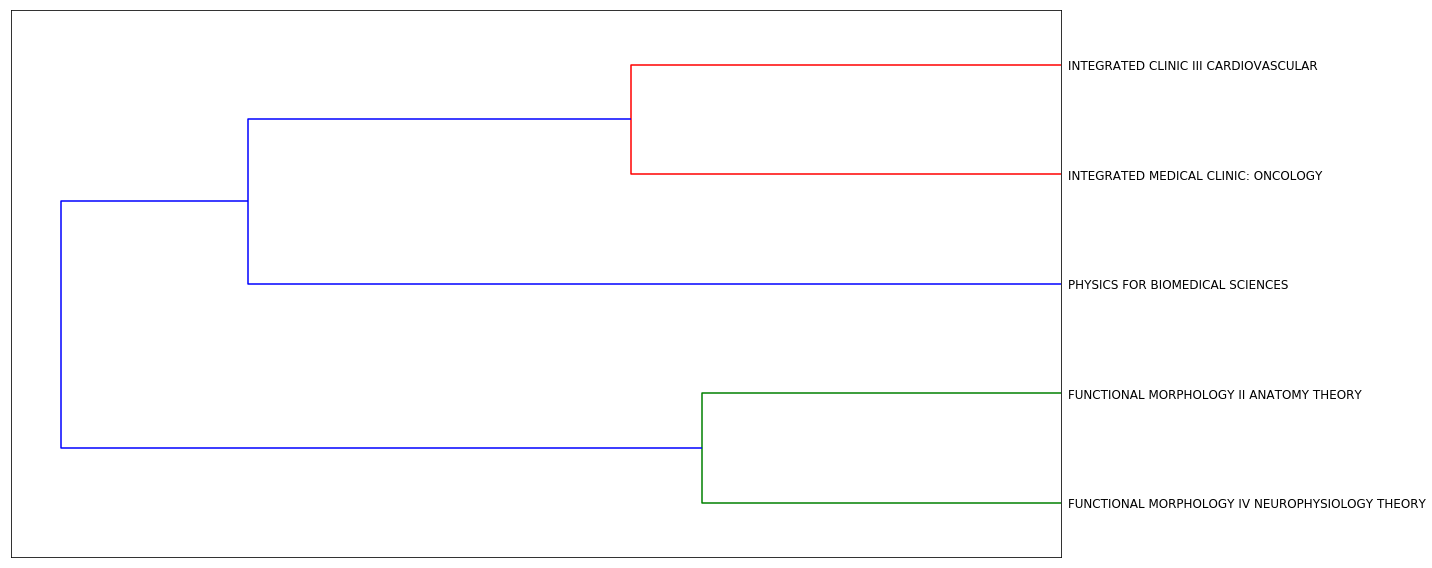

In [6]:
#Imprimir clusters con los labels de las materias
fig, ax = plt.subplots(figsize=(20,8)) # set size
ax = dendrogram(linkage_matrix, labels=lista_materias, orientation="left", distance_sort='ascending');

plt.tick_params( 
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False,
    grid_linewidth=50)

plt.tight_layout() #show plot with tight layout
#uncomment below to save figure
plt.savefig('clusters_materias_english.png', dpi=200) #save figure as ward_clusters

In [7]:
print ("1ra corrida - descendente")
T = to_tree( linkage_matrix , rd=False )
print (T.id)
print (T.pre_order(lambda x: x.id))
print ('------')
print ("2da corrida - descendente - nodo izq")
leftT1 = T.get_left()
print (leftT1.id)
print (leftT1.pre_order(lambda x: x.id))
print ('------')
print ("3ra corrida - descendente - nodo izq T1")
leftT2 = leftT1.get_left()
print (leftT2.id)
print (leftT2.pre_order(lambda x: x.id))
print ("3ra corrida - descendente - nodo der T1")
rightT2 = leftT1.get_right()
print (rightT2.id)
print (rightT2.pre_order(lambda x: x.id))
print ('------')
print ("2da corrida - descendente - nodo der")
rightT1 = T.get_right()
print (rightT1.id)
print (rightT1.pre_order(lambda x: x.id))
print ("3ra corrida - descendente - nodo izq T2")
leftT2_1 = rightT1.get_left()
print (leftT2_1.id)
print (leftT2_1.pre_order(lambda x: x.id))
print ("3ra corrida - descendente - nodo der T2")
rightT2_1 = rightT1.get_right()
print (rightT2_1.id)
print (rightT2_1.pre_order(lambda x: x.id))

1ra corrida - descendente
8
[3, 4, 0, 1, 2]
------
2da corrida - descendente - nodo izq
5
[3, 4]
------
3ra corrida - descendente - nodo izq T1
3
[3]
3ra corrida - descendente - nodo der T1
4
[4]
------
2da corrida - descendente - nodo der
7
[0, 1, 2]
3ra corrida - descendente - nodo izq T2
0
[0]
3ra corrida - descendente - nodo der T2
6
[1, 2]


In [10]:
"""
T = to_tree( linkage_matrix , rd=False )
if T.is_leaf() == False:
    print ("Es un cluster")
    if T.get_left() is not None:
        print ("Tiene un nodo hijo izq")
    else: print ("No tiene un nodo hijo izq")
        
else:
    print ("Es una observacion original")
"""
    
def add_node(node, padre):
    # First create the new node and append it to its parent's children
    newNode = dict(nodo=node.id, dist = round(node.dist, 2), hijo=[] )
    #print (newNode)
    padre['hijo'].append( newNode )
    #print (padre)
    # Recursively add the current node's children
    if node.get_left() is not None: add_node( node.get_left(), newNode)
    if node.get_right() is not None: add_node( node.get_right(), newNode)
    return padre

T = to_tree(linkage_matrix , rd=False )
dend = dict(nombre="root", hijo=[])
tree = add_node( T, dend )
print (tree)


"""
print (T.count)
print (T.dist)
print (T.get_count())
print (T.get_id())
print (T.get_left())
print (T.get_right())
print (T.id)
print (T.is_leaf())
print (T.pre_order(lambda x: x.id))
"""

{'nombre': 'root', 'hijo': [{'nodo': 8, 'dist': 2.0, 'hijo': [{'nodo': 5, 'dist': 0.72, 'hijo': [{'nodo': 3, 'dist': 0, 'hijo': []}, {'nodo': 4, 'dist': 0, 'hijo': []}]}, {'nodo': 7, 'dist': 1.62, 'hijo': [{'nodo': 0, 'dist': 0, 'hijo': []}, {'nodo': 6, 'dist': 0.86, 'hijo': [{'nodo': 1, 'dist': 0, 'hijo': []}, {'nodo': 2, 'dist': 0, 'hijo': []}]}]}]}]}


'\nprint (T.count)\nprint (T.dist)\nprint (T.get_count())\nprint (T.get_id())\nprint (T.get_left())\nprint (T.get_right())\nprint (T.id)\nprint (T.is_leaf())\nprint (T.pre_order(lambda x: x.id))\n'